<a href="https://colab.research.google.com/github/MekhzZ/opencv_bootcamp_exercise/blob/main/09_HDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Dynamic Range(HDR) Imaging

!["HDR Image Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_high-dynamic-range-hdr.jpg)

As we can see, left image with normal 8-bit color has less details than right one(hdr)

In [1]:
# importing required libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [3]:
# downloading assets

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

Basic Idea


1.   dynamic range of iamge is limited to 8-bits (0-255)
2.   very bright --> 255 , very low -->0



## Step 1 : Capture Multiple Exposures

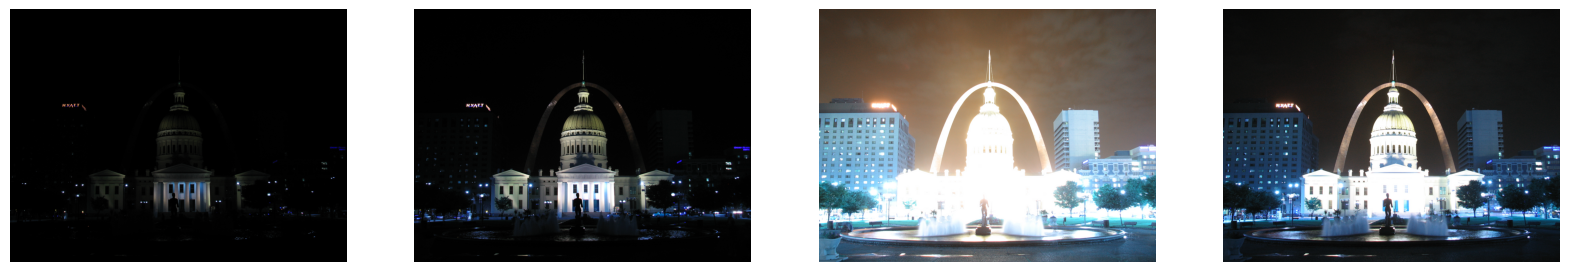

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1);plt.imshow(cv2.imread('/content/img_0.033.jpg'));plt.axis('off')
plt.subplot(1,4,2);plt.imshow(cv2.imread('/content/img_0.25.jpg'));plt.axis('off')
plt.subplot(1,4,3);plt.imshow(cv2.imread('/content/img_15.jpg'));plt.axis('off')
plt.subplot(1,4,4);plt.imshow(cv2.imread('/content/img_2.5.jpg'));plt.axis('off')
plt.show()

In [13]:
def readImagesAndTimes():
    # List of file names
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

## Step 2 : Align the images

In [14]:
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

cv2.createAlignMTB():

This algorithm converts images to median threshold bitmaps (1 for pixels brighter than median luminance and 0 otherwise) and than aligns the resulting bitmaps using bit operations.

It is invariant to exposure, so exposure values and camera response are not necessary.

In this implementation new image regions are filled with zeros.

## Step 3 : Estimate Camera Response Function

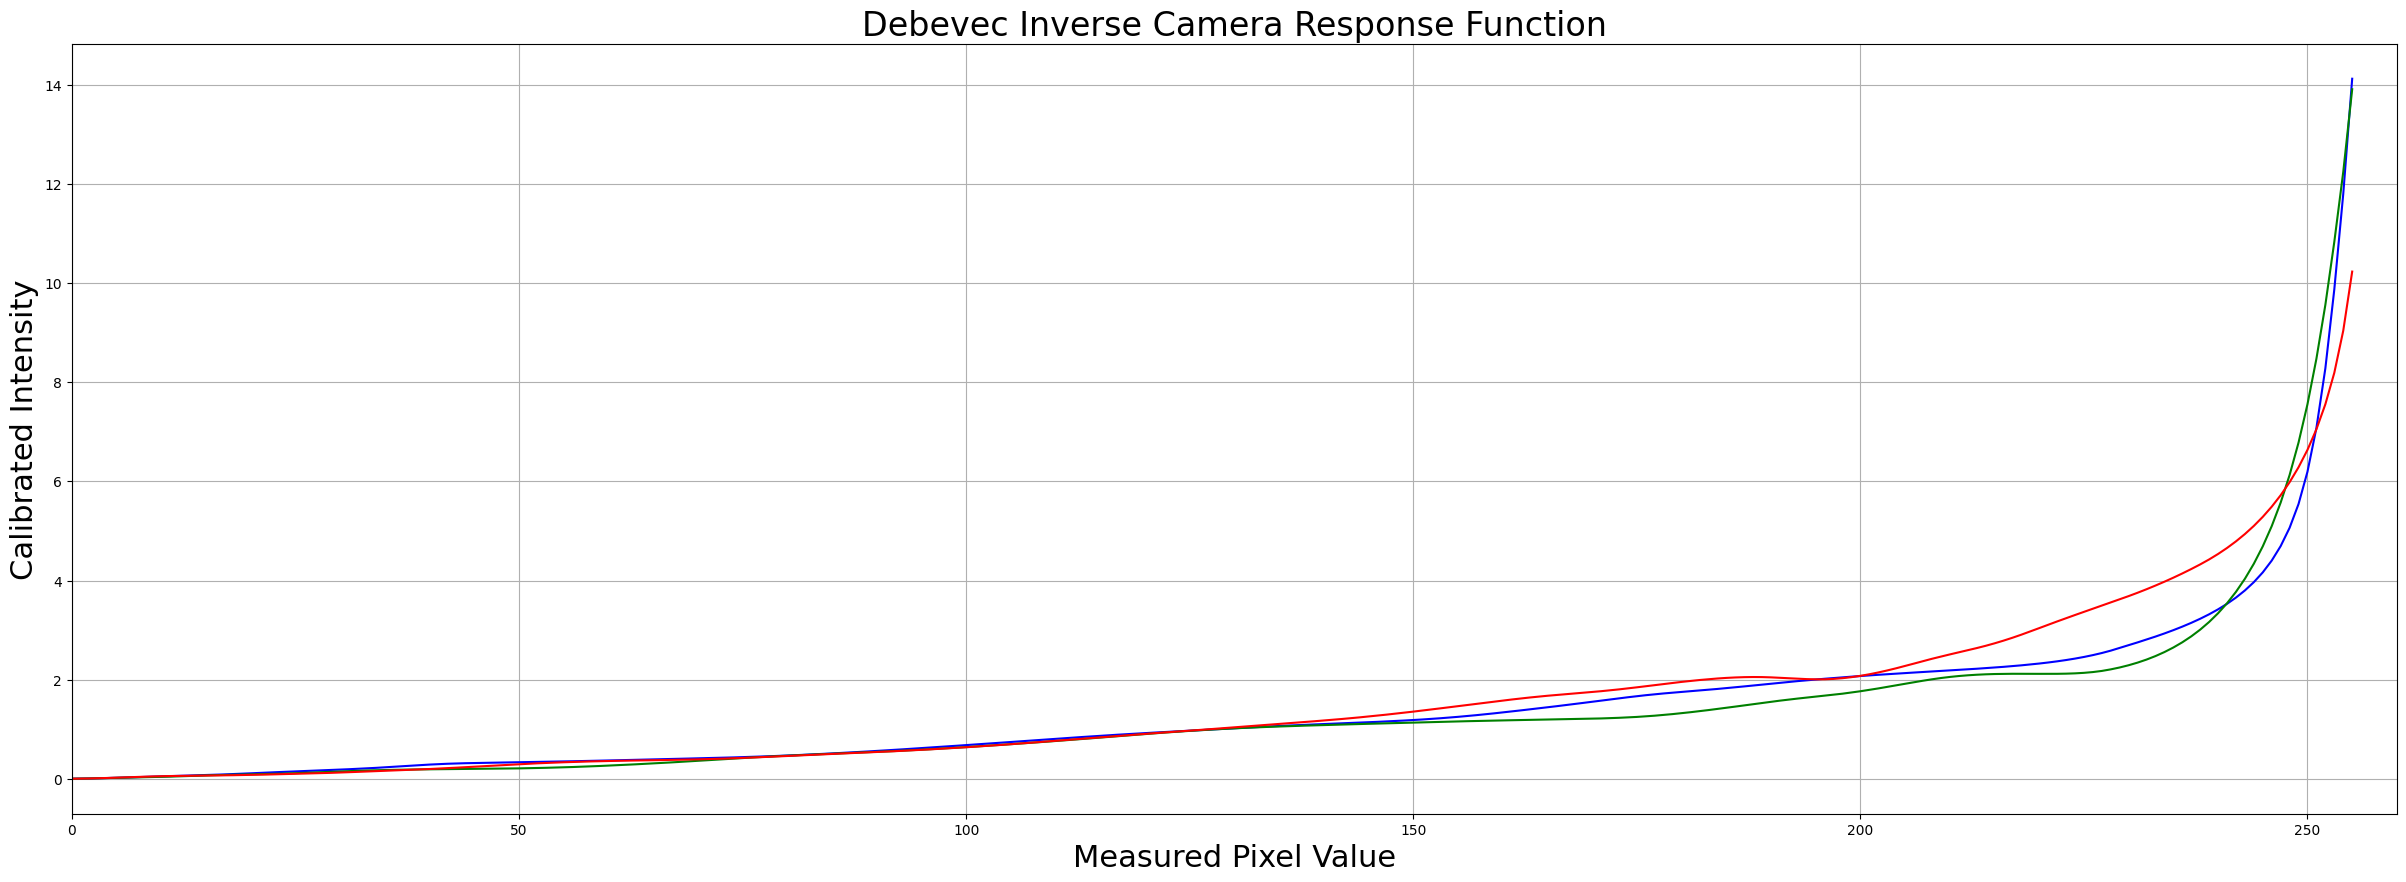

In [18]:
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")

cv2.createCalibrateDebevec() uses Debevec callibration algorithm to estimate the Camera Response Function (CRF) : the camera has different way to react in different level of lights, it's important to know them for HDR.

In essence, the images and their exposure times, uses the Debevec algorithm to estimate the camera's response to light, and then presents this response visually in a plot. This information is crucial for creating HDR images, as it helps to understand how the camera captures light and allows for adjustments to produce a more realistic and detailed image.

How Debevec algorithm works :

Imagine you have three photos of a scene—one underexposed, one correctly exposed, and one overexposed. The Debevec algorithm analyzes the pixel values across these images and figures out how the camera's sensor responded to the varying levels of light. It creates a curve (the CRF) that essentially "corrects" for the camera's non-linear response, allowing you to recover the true scene radiance.

---

What is Scene Radiance?



Scene radiance refers to the amount of light that is actually present in a real-world scene. It represents the physical quantity of light emanating from objects in the scene.


---


Why It's Necessary for HDR

HDR (High Dynamic Range) imaging aims to capture and display a wider range of light intensities than traditional imaging. Traditional images often lose details in very bright or very dark areas, a limitation called "dynamic range". True scene radiance data helps overcome this in a few key ways:

Recovering lost details: True scene radiance values preserve details that would be clipped (lost to pure white or pure black) in a standard image. By knowing the actual intensity of light in those areas, HDR can reconstruct a more accurate representation of the scene.
Realistic representation: HDR strives for realism, displaying scenes closer to how our eyes perceive them. Scene radiance is essential for achieving this realism, as it allows for recreating the natural variations in light intensity across a scene.
Flexibility in post-processing: With scene radiance data, you gain greater flexibility in editing and manipulating the image. You can adjust exposure, contrast, and other aspects without sacrificing details or introducing artifacts.

## Step 4 : Merge Exposure into and HDR Image

In [19]:
# Merge images into and HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

## Step 5 : Tonemapping

What is Tone Mapping?

Tone mapping is a computational photographic technique used to map one set of colors to another in order to approximate the appearance of high dynamic range (HDR) images in a medium that has a more limited dynamic range. Essentially, it's a way to bring the vast range of brightness levels in an HDR image down to a level that can be displayed on a standard screen.


---


Why is Tone Mapping Important for Visualizing HDR Images?

HDR images contain a much wider range of brightness values than traditional images. Our standard displays, like computer screens and phones, have a limited dynamic range and can't display the full range of brightness levels present in an HDR image. Without tone mapping, an HDR image would appear dull and flat on a standard display. Many details, especially in highlights and shadows, would be lost.

Tone mapping algorithms intelligently compress the brightness levels in the HDR image while preserving details and contrast. This allows us to see a more realistic and visually appealing representation of the HDR image on our displays.

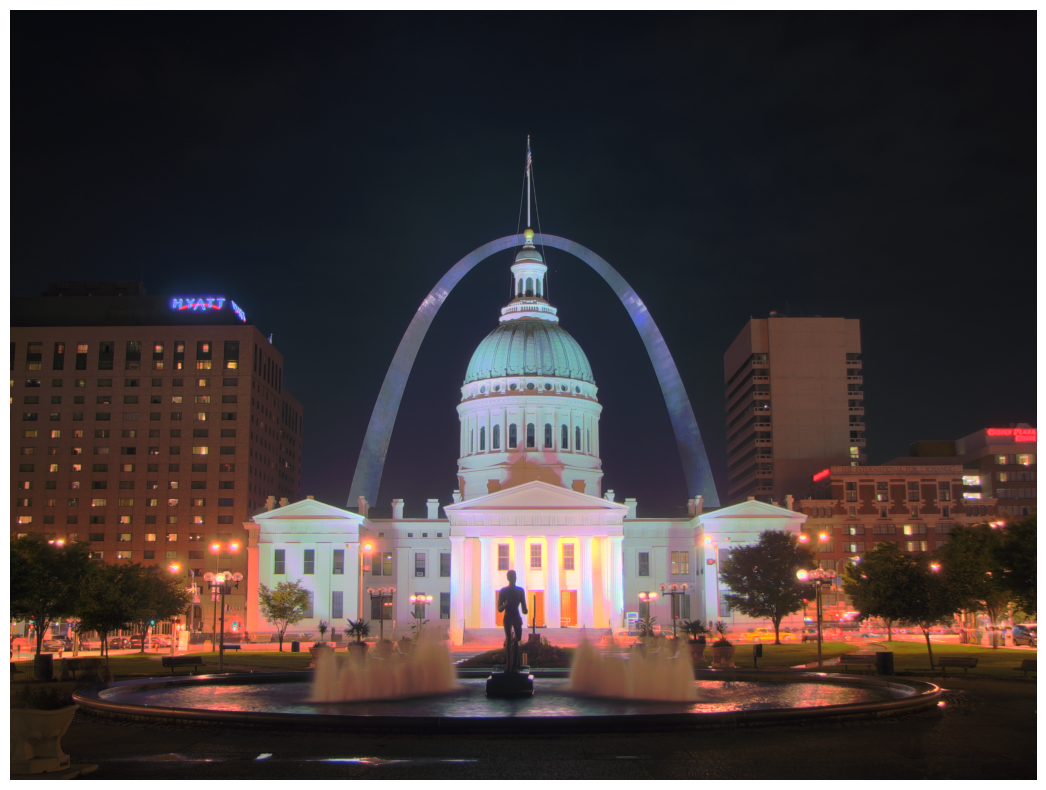

In [23]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

# Saving image
cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1]);plt.axis("off");

Drago's method :

1. Analyzing the HDR image to understand its brightness distribution.
2. Applying a modified logarithmic mapping to compress the dynamic range while preserving details.
3. Using a bias function to fine-tune the tone mapping curve for optimal contrast and detail.
4. Correcting any color shifts to maintain natural-looking colors.


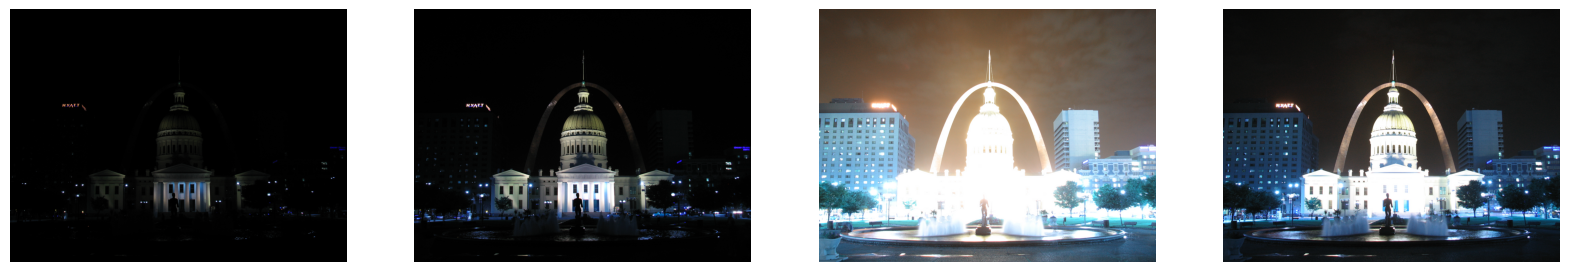

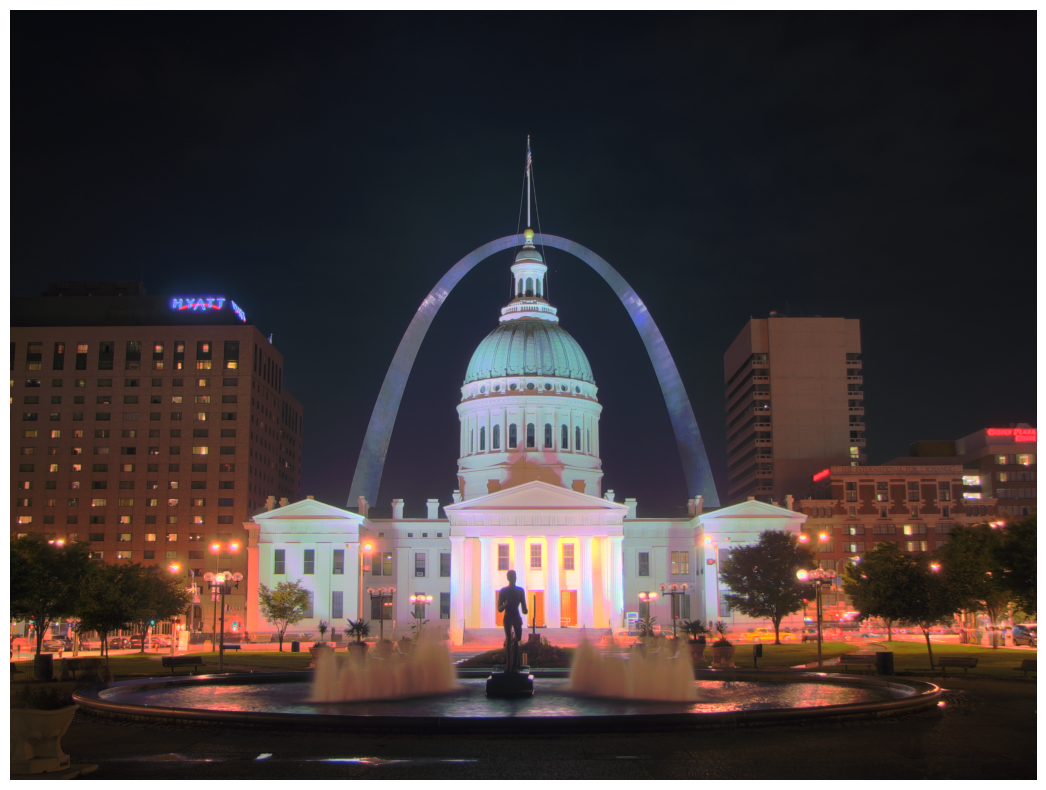

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1);plt.imshow(cv2.imread('/content/img_0.033.jpg'));plt.axis('off')
plt.subplot(1,4,2);plt.imshow(cv2.imread('/content/img_0.25.jpg'));plt.axis('off')
plt.subplot(1,4,3);plt.imshow(cv2.imread('/content/img_15.jpg'));plt.axis('off')
plt.subplot(1,4,4);plt.imshow(cv2.imread('/content/img_2.5.jpg'));plt.axis('off')
plt.show()

# Display the full-size HDR image below
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1])
plt.axis("off")
plt.show()

## Conclusion:

as above result, we worked on 4 different level of light exposured images and create one HDR image from them,

process:


1.   Aligned images properly using function of cv2 alignMTB that uses median threshold to align
2.   we used Debevec callibration algorithm to estimate CRF , which is useful for creation of hdr images as CRF shows how camera is behaving in different lights level. and distinguish the nature light present while capturing photo.
3. Merged the images after processing response of cameras with exposure times and images
4. Tonemapping the hdr images to make it display in  our normal screen as our normal screen is not able to display hdr in it's original form

